In [1]:
import logging
import time
import psutil
import socket
import numpy as np
from hermes.aeriel.client import InferenceClient
from tqdm import tqdm
from matplotlib import pyplot as plt
from infer.data import Sequence
from infer.postprocess import Postprocessor
import os
import logging
from typing import Optional

import h5py
import hermes.quiver as qv
import torch
import io
from utils.s3 import open_file
from hermes.aeriel.client import InferenceClient
from infer.data import Sequence
from infer.main import infer
from infer.postprocess import Postprocessor
from tqdm.notebook import tqdm
from utils.mm_preprocessing import BackgroundSnapshotter, mm_BatchWhitener
import sys
sys.path.append('/home/seiya.tsukamoto/aframe/projects/export/')

from export.mm_modules import concatenation_layer
sys.path.append('/home/seiya.tsukamoto/aframe/projects/train/')

def get_ip_address() -> str:
    """
    Get the local nodes cluster-internal IP address
    """
    for _, addrs in psutil.net_if_addrs().items():
        for addr in addrs:
            if (
                addr.family == socket.AF_INET
                and not addr.address.startswith("127.")
            ):
                return addr.address
    raise ValueError("No valid IP address found")

/usr/local/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
ifos = ['H1','L1']
batch_size = 128
rate_per_client = 10
shifts = [0, 1]
fname = '/home/seiya.tsukamoto/aframe/mm_v1/data/test/background/background-1241569755-20000.hdf5'
injection_set_fname = '/home/seiya.tsukamoto/aframe/mm_v1/data/test/waveforms.hdf5'
integration_window_length = 6
cluster_window_length = 32
psd_length = 64
fduration = 1
model_name = 'aframe-stream'
model_version = 1
triton_image = 'hermes/tritonserver:23.01'
sequence_id = '1001'
inference_psd_length = 64
inference_batch_size = 128
address = '/home/seiya.tsukamoto/aframe/mm_v1/mm_v1/results/model_repo/'
batch_size = 128
weights = '/home/seiya.tsukamoto/aframe/mm_v1/mm_v1/training/model.pt'
batch_file = '/home/seiya.tsukamoto/aframe/mm_v1/mm_v1/training/batch.h5'
aframe_instances = None
num_ifos = 2
kernel_length = 2.375
sample_rate = 2048
classes = [64, 64, 64, 64]
#layers = [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
inference_sampling_rates = [8, 4, 2, 8]
sample_rate=2048
inference_sampling_rate=8
fduration=1
fftlength=None
q = None
highpass=1024
lowpass=32
preproc_instances=None
streams_per_gpu=6
resample_rates = [2048, 1024, 512, 2048]
kernel_lengths = [0.5, 1, 2, 1]
high_passes = [32, 32, 32, 32]
low_passes = [1024, 128, 64, 1024]
starting_offsets = [0, 1, 3, 0]
fftlength = fftlength or kernel_length + fduration

In [3]:
logging.info("Initializing model graph")
with open_file(weights, "rb") as f:
    graph = torch.jit.load(f, map_location="cpu")
graph.eval()
logging.info(f"Initialize:\n{graph}")
with open_file(batch_file, "rb") as f:
    batch_file = h5py.File(io.BytesIO(f.read()))
layers = sorted(batch_file.keys() - "y")
input_shapes = [(batch_size*inference_sampling_rates[i]//max(inference_sampling_rates), 
                 batch_file[layer].shape[-2], 
                 batch_file[layer].shape[-1]) for i, layer in enumerate(layers)]
n_layers = len(layers)
graphs = []
model_parent_dir = os.path.dirname(weights)
for i in range(n_layers):
    with open_file(os.path.join(model_parent_dir, f"resnets_{i}.pt"), "rb") as f:
        graphs.append(torch.jit.load(f, map_location="cpu"))
        graphs[-1].eval()
with open_file(os.path.join(model_parent_dir, f"fc.pt"), "rb") as f:
    fc = torch.jit.load(f, map_location="cpu")
    fc.eval()

cl  = concatenation_layer(inference_sampling_rates)
snapshotter = BackgroundSnapshotter(
    psd_length=psd_length,
    kernel_length=kernel_length,
    fduration=fduration,
    sample_rate=sample_rate,
    inference_sampling_rate=inference_sampling_rate,
)

preprocessor = mm_BatchWhitener(
    resample_rates = resample_rates, 
    kernel_lengths = kernel_lengths, 
    high_passes = high_passes, 
    low_passes = low_passes,
    inference_sampling_rates = inference_sampling_rates,
    starting_offsets = starting_offsets,
    num_ifos = num_ifos,
    kernel_length=kernel_length,
    sample_rate=sample_rate,
    batch_size=batch_size,
    fduration=fduration,
    fftlength=fftlength,
)

In [4]:
sequence = Sequence(
    ifos=ifos,
    batch_size=batch_size,
    inference_sampling_rate=inference_sampling_rate,
    rate=rate_per_client,
    shifts=shifts,
    background_fname=fname,
    injection_set_fname=injection_set_fname,
)
postprocessor = Postprocessor(
    integration_window_length=integration_window_length,
    inference_sampling_rate=inference_sampling_rate,
    cluster_window_length=cluster_window_length,
    psd_length=psd_length,
    fduration=fduration,
    t0=sequence.t0,
    shifts=shifts,
)

In [5]:
device = torch.device('cuda:1')

In [6]:
snapshotter.to(device)
preprocessor.to(device)
graphs[0].to(device)
graphs[1].to(device)
graphs[2].to(device)
graphs[3].to(device)
cl.to(device)
fc.to(device)

RecursiveScriptModule(original_name=Linear)

In [7]:
iterator = iter(enumerate(sequence))
i, (x, x_inj) = next(iterator)
snapshot = np.stack([x, x_inj])
snapshot = torch.tensor(snapshot).to(device)
for _ in range(6):
    i, (x, x_inj) = next(iterator)
    inputs = np.stack([x, x_inj])
    inputs = torch.tensor(inputs).to(device)
    snapshotter_out, snapshot = snapshotter(inputs, snapshot)
    print(snapshotter_out.shape)

timeseries = []

torch.Size([2, 2, 65536])
torch.Size([2, 2, 98304])
torch.Size([2, 2, 131072])
torch.Size([2, 2, 163840])
torch.Size([2, 2, 170496])
torch.Size([2, 2, 170496])


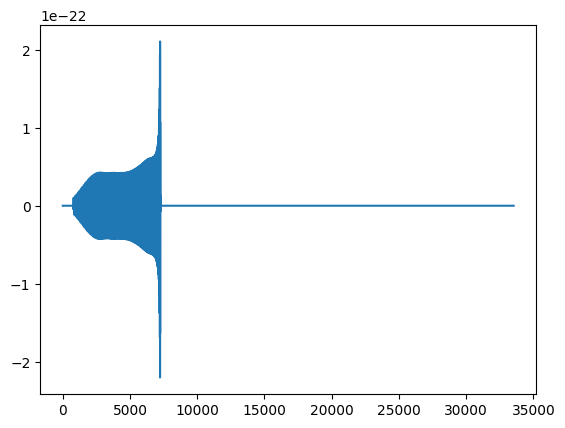

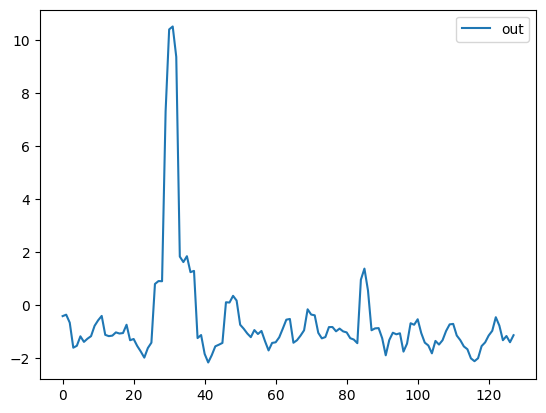

In [17]:
i, (x, x_inj) = next(iterator)
inputs = np.stack([x, x_inj])
inputs = torch.tensor(inputs).to(device)
snapshotter_out, snapshot = snapshotter(inputs, snapshot)
plt.plot(snapshotter_out[0][0][int(66.875*2048):].cpu()-snapshotter_out[1][0][int(66.875*2048):].cpu())
plt.show()
plt.close()
whitened_0, whitened_1, whitened_2, whitened_3 = preprocessor(snapshotter_out)
with torch.no_grad():
    out_0 = graphs[0](whitened_0)
    out_1 = graphs[1](whitened_1)
    out_2 = graphs[2](whitened_2)
    out_3 = graphs[3](whitened_3)
concated = cl(out_0, out_1, out_2, out_3)
with torch.no_grad():
    out = fc(concated)
#plt.plot(np.arange(0, 128, 1), torch.sum(out_0**2, dim = 1).cpu(), label = 'out_0')
#plt.plot(np.arange(0, 128, 2), torch.sum(out_1**2, dim = 1).cpu(), label = 'out_1')
#plt.plot(np.arange(0, 128, 4), torch.sum(out_2**2, dim = 1).cpu(), label = 'out_2')
#plt.plot(np.arange(0, 128, 1), torch.sum(out_3**2, dim = 1).cpu(), label = 'out_3')
plt.plot(np.arange(0, 128, 1), out.squeeze(dim = 1).cpu(), label = 'out')
plt.legend()
plt.show()
plt.close()
timeseries = np.concatenate([timeseries, out.squeeze(dim = 1).cpu()])

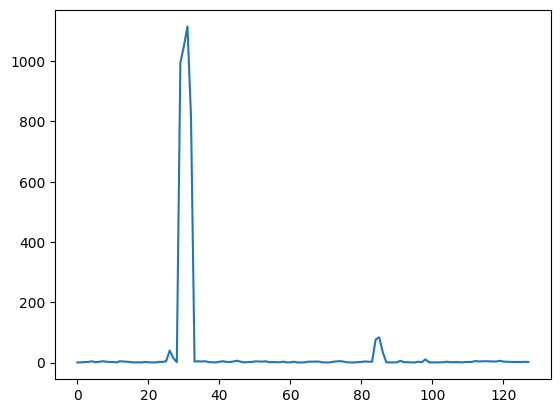

In [18]:
plt.plot(np.arange(0, 128, 1), torch.sum(out_0**2, dim = 1).cpu(), label = 'out_0')

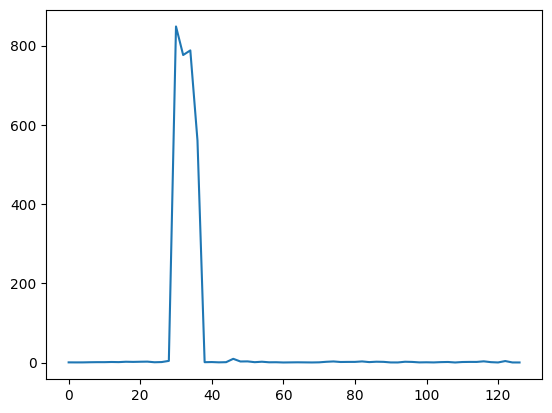

In [19]:
plt.plot(np.arange(0, 128, 2), torch.sum(out_1**2, dim = 1).cpu(), label = 'out_1')

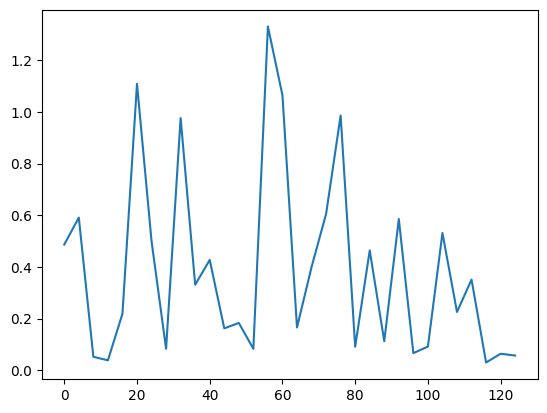

In [20]:
plt.plot(np.arange(0, 128, 4), torch.sum(out_2**2, dim = 1).cpu(), label = 'out_2')

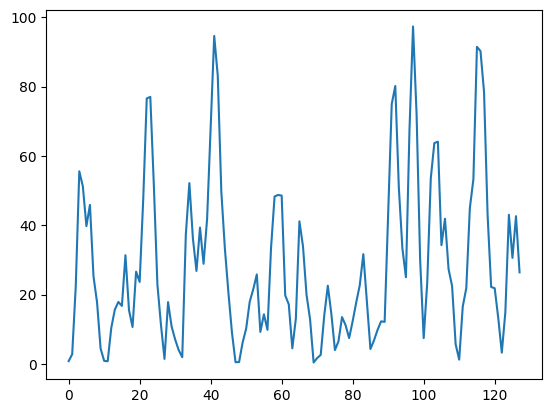

In [21]:
plt.plot(np.arange(0, 128, 1), torch.sum(out_3**2, dim = 1).cpu(), label = 'out_3')

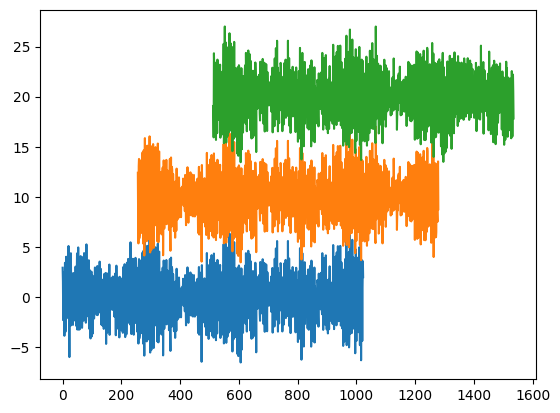

In [24]:
plt.plot(np.arange(0, 1024, 1), whitened_0[18][0].cpu())
plt.plot(np.arange(256, 1024+256, 1), whitened_0[19][0].cpu()+10)
plt.plot(np.arange(512, 1024+512, 1), whitened_0[20][0].cpu()+20)

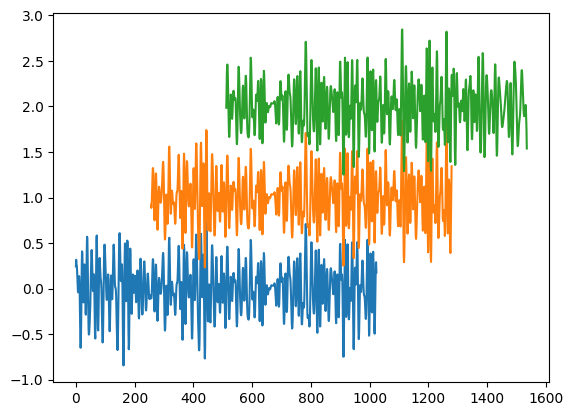

In [25]:
plt.plot(np.arange(0, 1024, 1), whitened_1[9][0].cpu())
plt.plot(np.arange(256, 1024+256, 1), whitened_1[10][0].cpu()+1)
plt.plot(np.arange(512, 1024+512, 1), whitened_1[11][0].cpu()+2)

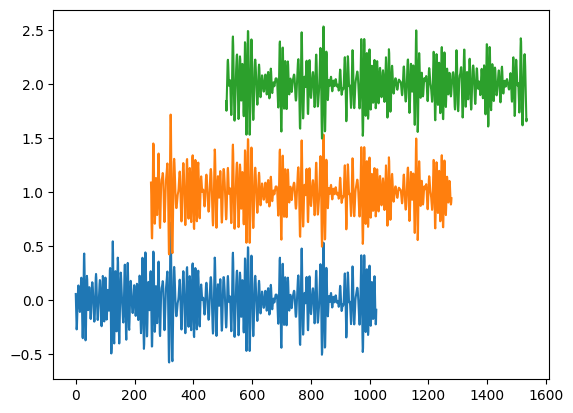

In [26]:
plt.plot(np.arange(0, 1024, 1), whitened_2[4][0].cpu())
plt.plot(np.arange(256, 1024+256, 1), whitened_2[5][0].cpu()+1)
plt.plot(np.arange(512, 1024+512, 1), whitened_2[6][0].cpu()+2)

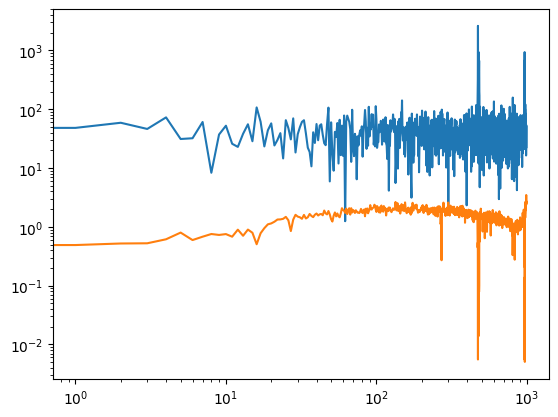

In [28]:
plt.plot((whitened_3[0][0].cpu()**2+whitened_3[0][2].cpu()**2)**.5)
plt.plot(whitened_3[0][4].cpu())
plt.xscale('log')
plt.yscale('log')

In [13]:
iterator = iter(enumerate(sequence))
i, (x, x_inj) = next(iterator)
snapshot = np.stack([x, x])
snapshot = torch.tensor(snapshot).to(device)
for _ in range(6):
    i, (x, x_inj) = next(iterator)
    inputs = np.stack([x, x])
    inputs = torch.tensor(inputs).to(device)
    snapshotter_out, snapshot = snapshotter(inputs, snapshot)
    print(snapshotter_out.shape)

bg_timeseries = []

torch.Size([2, 2, 65536])
torch.Size([2, 2, 98304])
torch.Size([2, 2, 131072])
torch.Size([2, 2, 163840])
torch.Size([2, 2, 170496])
torch.Size([2, 2, 170496])


In [14]:
for i, (x, x_inj) in tqdm(enumerate(sequence)):
    inputs = np.stack([x, x])
    inputs = torch.tensor(inputs).to(device)
    snapshotter_out, snapshot = snapshotter(inputs, snapshot)
    whitened_0, whitened_1, whitened_2, whitened_3 = preprocessor(snapshotter_out)
    with torch.no_grad():
        out_0 = graphs[0](whitened_0)
        out_1 = graphs[1](whitened_1)
        out_2 = graphs[2](whitened_2)
        out_3 = graphs[3](whitened_3)
    concated = cl(out_0, out_1, out_2, out_3)
    with torch.no_grad():
        out = fc(concated)
    bg_timeseries = np.concatenate([bg_timeseries, out.squeeze(dim = 1).cpu()])

0it [00:00, ?it/s]

In [8]:
for i, (x, x_inj) in tqdm(enumerate(sequence)):
    inputs = np.stack([x, x_inj])
    inputs = torch.tensor(inputs).to(device)
    snapshotter_out, snapshot = snapshotter(inputs, snapshot)
    #plt.plot(snapshotter_out[0][0][int(66.875*2048):].cpu()-snapshotter_out[1][0][int(66.875*2048):].cpu())
    #plt.show()
    #plt.close()
    whitened_0, whitened_1, whitened_2, whitened_3 = preprocessor(snapshotter_out)
    with torch.no_grad():
        out_0 = graphs[0](whitened_0)
        out_1 = graphs[1](whitened_1)
        out_2 = graphs[2](whitened_2)
        out_3 = graphs[3](whitened_3)
    concated = cl(out_0, out_1, out_2, out_3)
    with torch.no_grad():
        out = fc(concated)
    #plt.plot(np.arange(0, 128, 1), torch.sum(out_0**2, dim = 1).cpu(), label = 'out_0')
    #plt.plot(np.arange(0, 128, 2), torch.sum(out_1**2, dim = 1).cpu(), label = 'out_1')
    #plt.plot(np.arange(0, 128, 4), torch.sum(out_2**2, dim = 1).cpu(), label = 'out_2')
    #plt.plot(np.arange(0, 128, 1), torch.sum(out_3**2, dim = 1).cpu(), label = 'out_3')
    #plt.plot(np.arange(0, 128, 1), out.squeeze(dim = 1).cpu(), label = 'out')
    #plt.legend()
    #plt.show()
    #plt.close()
    timeseries = np.concatenate([timeseries, out.squeeze(dim = 1).cpu()])

0it [00:00, ?it/s]

In [16]:
fg_out = postprocessor(timeseries)
bg_out = postprocessor(bg_timeseries)

In [17]:
recovered = sequence.recover(pp_out)

In [40]:
bg_out.write('/home/seiya.tsukamoto/aframe/mm_v1/mm_v1/infer_testing/background.hdf5')
recovered.write('/home/seiya.tsukamoto/aframe/mm_v1/mm_v1/infer_testing/foreground.hdf5')